In [1]:
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import display, Markdown, Image
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.agents import Tool
import json
import uuid

import gradio as gr

In [2]:
load_dotenv(override=True)

True

In [3]:
class Decider(TypedDict):
    requires_structure: bool = Field(description="if structued data is required")
    requires_tool: bool = Field(description="if tool llm is required")
    response: str = Field(description="your response")

In [4]:
class MovieReview(TypedDict):
    name : str = Field(description="The name of the movie")
    genre: str = Field(description="The genre of the movie, e.g., 'Action', 'Comedy', etc.")
    review: str = Field(description="The movie review text")
    sentiment: str = Field(description="The sentiment of the review, either 'positive' or 'negative'")
    imdb_rating: float = Field(description="The IMDb rating of the movie, a float between 0 and 10")
    parents_guide: str = Field(description="A brief parents guide for the movie")
    rated_for: str = Field(description="The age group the movie is rated for, e.g., 'PG-13', 'R', etc.")

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    requires_structure: Annotated[bool, "if the response requires structured output"]
    requires_tool: Annotated[bool, "if the response requires tool use"]

In [6]:
# import nest_asyncio
# from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
# from langchain_community.tools.playwright.utils import create_async_playwright_browser

# nest_asyncio.apply()

# async_browser = create_async_playwright_browser(headless=False)
# toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
# tools = toolkit.get_tools()

In [7]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()

tool_search = Tool(
    name = "web_search",
    func=serper.run,
    description="Useful for when you need to do a web search"
)

tools = [tool_search]

In [8]:
worker_llm = ChatOpenAI(model="gpt-4o-mini")
worker_llm_with_tools = worker_llm.bind_tools(tools)
wroker_llm_structured_output = worker_llm.with_structured_output(MovieReview)
worker_llm_decider = worker_llm.with_structured_output(Decider)

In [9]:
def print_messages(state: State):
    for msg in state["messages"]:
        if isinstance(msg, dict):  # your manual dict messages
            role = msg.get("role", "unknown")
            content = msg.get("content", "")
        else:  # AIMessage / HumanMessage / SystemMessage
            role = getattr(msg, "type", msg.__class__.__name__)
            content = getattr(msg, "content", "")
        print(f"{role}: {content}")

In [10]:
def llm_decider(old_state: State) -> State:
    system_message = "You are a movie review assistant. " \
    "If someone asks for a movie review, you will use your tools to get the latest information and set the requires_structure to True " \
    "and finally provide a structured output" \
    "But if they continue a normal conversation, you will respond normally but keep movie directed. " \
    "If you need to look something up, use the tools provided."

    found_system_message = False
    messages = old_state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            print("found system message")
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        print("not found system message, adding one")
        messages = [{'role': 'system', 'content': system_message}] + messages

    print_messages(old_state)
    print(f"Invoking LLM decider...")
    response = worker_llm_decider.invoke(old_state['messages'])
    print(response)
    state = State(messages=[{'role': 'assistant', 'content': response['response']}], 
                  requires_structure=response.get('requires_structure', False),
                  requires_tool=response.get('requires_tool', False))
    return state

In [11]:
def llm_worker_node(old_state: State) -> State:
    print_messages(old_state)
    print(f"Invoking LLM worker with tools... requires_structure: {old_state.get('requires_structure')}")
    response = worker_llm_with_tools.invoke(old_state['messages'])
    print(f"LLM worker response: {response}")
    messages = [response]
    state = State(messages = messages, requires_structure=old_state['requires_structure'], requires_tool=old_state['requires_tool'])
    return state

In [12]:
def llm_strcuture_node(old_state: State) -> State:
    print_messages(old_state)
    print(f"Invoking LLM worker for structured output... requires_structure: {old_state.get('requires_structure')}")
    response = wroker_llm_structured_output.invoke(old_state["messages"])
    messages = [{'role': 'assistant', 'content': json.dumps(response)}]
    state = State(messages = messages, requires_structure=old_state['requires_structure'], requires_tool=old_state['requires_tool'])
    return state

In [13]:
def route_decider(state: State) -> str:
    last = state["messages"][-1]
    if state.get("requires_tool"):
        return "tools"
    if state.get("requires_structure"):
        return "structured"
    return END

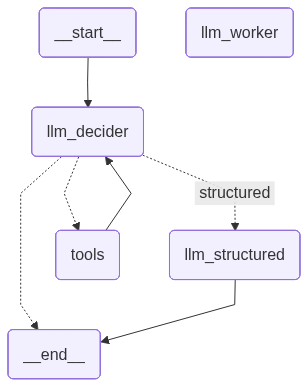

In [14]:
graph_builder = StateGraph(State)

graph_builder.add_node("llm_decider", llm_decider)
graph_builder.add_node("llm_worker", llm_worker_node)
graph_builder.add_node("llm_structured", llm_strcuture_node)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "llm_decider")
# graph_builder.add_edge(START, "llm_structured")
graph_builder.add_conditional_edges("llm_decider", route_decider, {"tools": "tools", "structured": "llm_structured", END: END})
graph_builder.add_edge("tools", "llm_decider")
# graph_builder.add_edge("llm_worker", END)


memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [348]:
def make_thread_id() -> str:
    return str(uuid.uuid4())

config = {"configurable": {"thread_id": make_thread_id()}}

def chat(user_message, history):
    system_message = "You are a movie review assistant. If someone asks for a movie review, you will set the requires_structure to True " \
    "and provide a structured output" \
    "But if they continue a normal conversation, you will respond normally. If you need to look something up, use the tools provided."
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
        ]
    state = State(messages=messages, requires_structure=False, requires_tool=False)
    new_state = graph.invoke(state, config=config)
    return new_state["messages"][-1].content

gr.ChatInterface(fn=chat, title="LangGraph LLM Test").launch()

/mnt/d/Work/Projects/Ubuntu_Home/projects/ownership-ai/.venv/lib/python3.12/site-packages/gradio/chat_interface.py:345: UserWarning: The 'tuples' format for chatbot messages is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  self.chatbot = Chatbot(


* Running on local URL:  http://127.0.0.1:7918
* To create a public link, set `share=True` in `launch()`.


found system message
system: You are a movie review assistant. If someone asks for a movie review, you will use your tools to get the latest information and set the requires_structure to True and finally provide a structured outputBut if they continue a normal conversation, you will respond normally but keep movie directed. If you need to look something up, use the tools provided.
human: Hey
Invoking LLM decider...
{'requires_structure': False, 'requires_tool': False, 'response': "Hey! How's it going? Are you in the mood for a movie, or do you want to chat about something else?"}
found system message
found system message
system: You are a movie review assistant. If someone asks for a movie review, you will use your tools to get the latest information and set the requires_structure to True and finally provide a structured outputBut if they continue a normal conversation, you will respond normally but keep movie directed. If you need to look something up, use the tools provided.
human: H

Traceback (most recent call last):
  File "/mnt/d/Work/Projects/Ubuntu_Home/projects/ownership-ai/.venv/lib/python3.12/site-packages/gradio/queueing.py", line 667, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/Work/Projects/Ubuntu_Home/projects/ownership-ai/.venv/lib/python3.12/site-packages/gradio/route_utils.py", line 349, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/Work/Projects/Ubuntu_Home/projects/ownership-ai/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 2274, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/Work/Projects/Ubuntu_Home/projects/ownership-ai/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 1779, in call_function
    prediction = await fn(*processed_input)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt